## Section 4.4 - Spectroscopic Calibration

1. Below is the image of the 3 slits from the spectrograph with a Neon arc lamp:

Text(0.5, 1.0, 'Full Spectrum Columns')

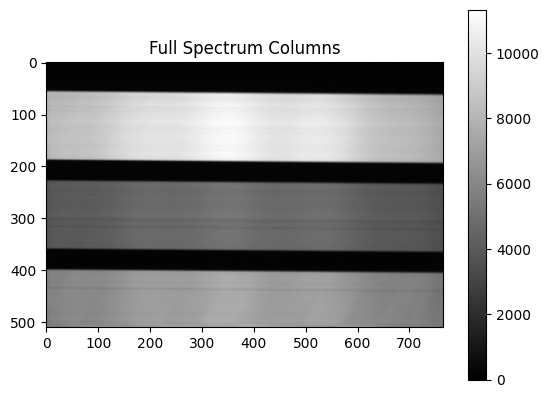

In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

spectra_image = fits.open('../Lab_1/images/lab1_3_4_8.00000009.FIT')

data = spectra_image[0].data
plt.imshow(data,cmap='gray')
plt.colorbar()
plt.title('Full Spectrum Columns')

(200, 765)


Text(0.5, 1.0, '50$\\mu$m Slit Crop')

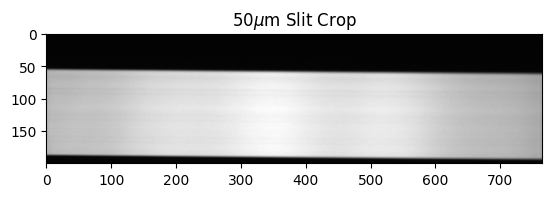

In [3]:
#Crop data to only include the top band (50um)

crop = data[:200,:]
print(crop.shape)
plt.imshow(crop,cmap='gray')
plt.title(r'50$\mu$m Slit Crop')

In [4]:
flat_list = []

# find and open the Flat Fields and store them all in one list
file_prefix = "lab1_3_4_8.0000000"
file_end = ".FIT"
pixel_data = [None]*9

for i in range(0, 9, 1):
    filename = file_prefix + str(i) + file_end
    list = fits.open('../Lab_1/images/'+filename)
    image_data = list[0].data
    pixel_data[i] = image_data


# open a 2d list to store median values
median_values = np.zeros((200, 765)) #the cropped image is a 200 x 765 pixel array

# run through and calculate the median value for each pixel, 200 for y-axis and 765 for x-axis
for i in range(0, 200):
    for j in range(0, 765):
        values = [pixel_data[x][i][j] for x in range(0,9)]
        median_values[i][j] = np.median(values)

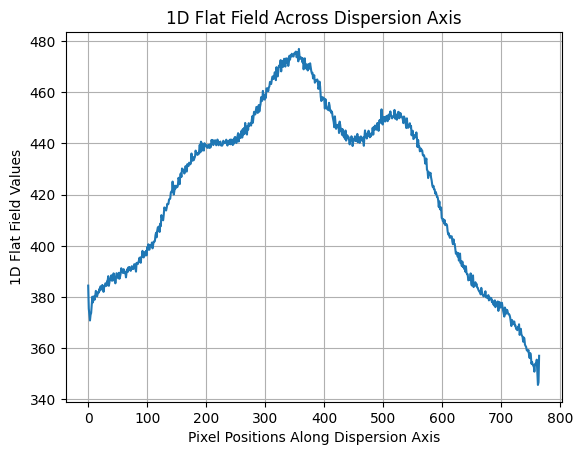

In [5]:
# Calculate the 1D flat field values by averaging along the y-axis
flat_field_1d = np.mean(median_values, axis=0)

# Plotting the 1D flat field values against pixel positions along the dispersion axis
dispersion_axis = np.arange(765) 

plt.plot(dispersion_axis, flat_field_1d)
plt.xlabel('Pixel Positions Along Dispersion Axis')
plt.ylabel('1D Flat Field Values')
plt.title('1D Flat Field Across Dispersion Axis')
plt.grid(True)
plt.show()

 [astropy.modeling.fitting]


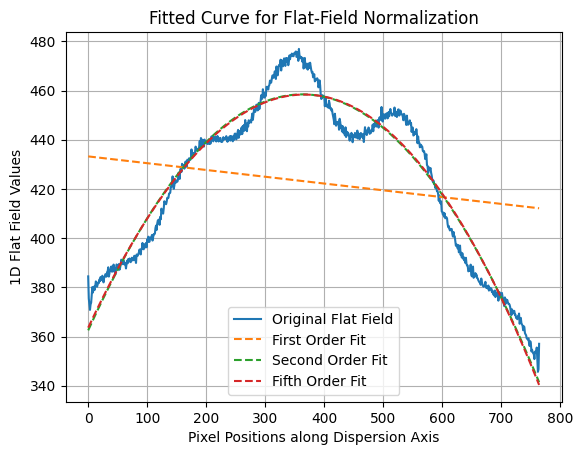

In [6]:
from astropy.modeling import models, fitting

# Pixel positions along the dispersion axis
dispersion_axis = np.arange(765)  #765 is the length of the dispersion axis

# Initialize various polynomial models for fitting
first_order = models.Polynomial1D(degree=1)
second_order = models.Polynomial1D(degree=2)
fifth_order = models.Polynomial1D(degree=5)


# Initialize a fitting algorithm
fitter = fitting.LinearLSQFitter()

# Fit the models to the 1D flat-field spectrum
first_fit = fitter(first_order, dispersion_axis, flat_field_1d)
second_fit = fitter(second_order, dispersion_axis, flat_field_1d)
fifth_fit = fitter(fifth_order, dispersion_axis, flat_field_1d)

# Generate the fits using the fitted model
first_fit_curve = first_fit(dispersion_axis)
second_fit_curve = second_fit(dispersion_axis)
fifth_fit_curve = fifth_fit(dispersion_axis)

# Plot the original flat-field and the fitted curves
plt.plot(dispersion_axis, flat_field_1d, label='Original Flat Field')
plt.plot(dispersion_axis, first_fit(dispersion_axis), label='First Order Fit', linestyle='--')
plt.plot(dispersion_axis, second_fit(dispersion_axis), label='Second Order Fit', linestyle='--')
plt.plot(dispersion_axis, fifth_fit(dispersion_axis), label='Fifth Order Fit', linestyle='--')
plt.xlabel('Pixel Positions along Dispersion Axis')
plt.ylabel('1D Flat Field Values')
plt.title('Fitted Curve for Flat-Field Normalization')
plt.legend()
plt.grid(True)
plt.show()

# Divide the 2D flat-field by the fits to obtain the normalized flat-field
first_normalized_flat_field = median_values / first_fit_curve
second_normalized_flat_field = median_values / second_fit_curve
fifth_normalized_flat_field = median_values / fifth_fit_curve

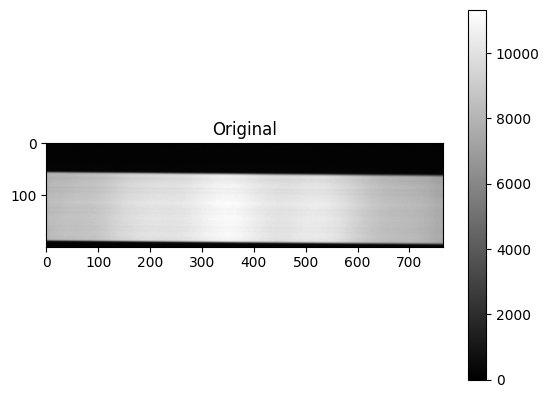

In [7]:
plt.imshow(crop,cmap='gray')
plt.title('Original')
plt.colorbar()

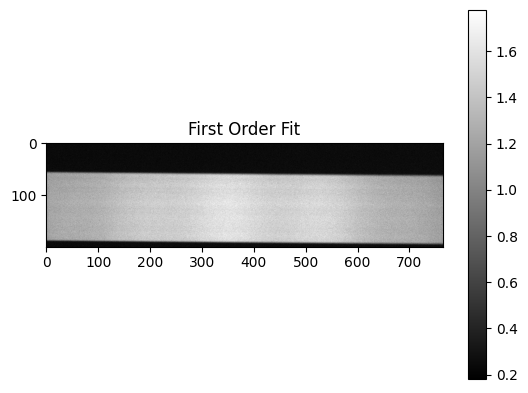

In [8]:
plt.imshow(first_normalized_flat_field,cmap='gray')
plt.title('First Order Fit')
plt.colorbar()

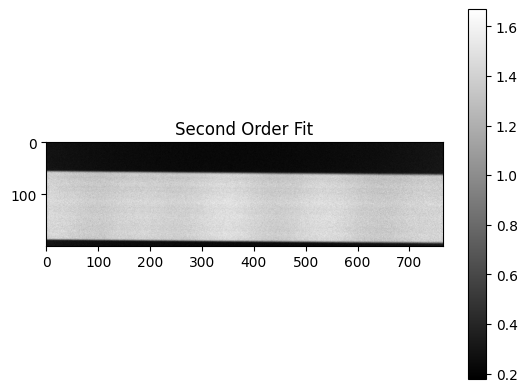

In [9]:
plt.imshow(second_normalized_flat_field,cmap='gray')
plt.title('Second Order Fit')
plt.colorbar()

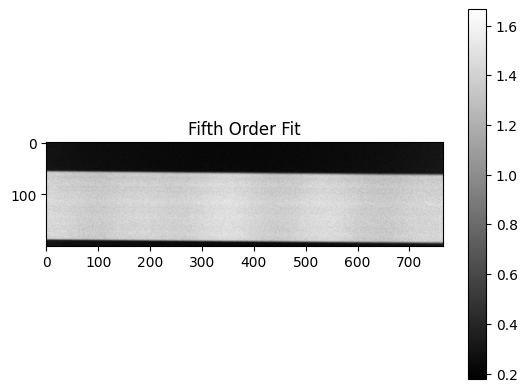

In [10]:
plt.imshow(fifth_normalized_flat_field,cmap='gray')
plt.title('Fifth Order Fit')
plt.colorbar()

It seems as though the higher the order of the fit, the more evenly distributed the pixel counts.

4.4 Below is the full arc lamp spectra:

Text(0.5, 1.0, 'Arc Lamp Spectra')

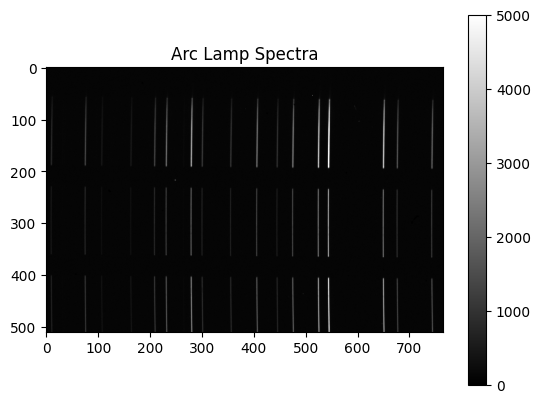

In [11]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

spectra = fits.open('../Lab_1/images/lab1_3_4_7_actual.00000002.FIT')

spectra_data = spectra[0].data
plt.imshow(spectra_data,cmap='gray',vmax=5000)
plt.colorbar()
plt.title('Arc Lamp Spectra')

Taking the top row, which corresponds to the 50um slit, and applying the normalized flat field:

(200, 765)


Text(0.5, 1.0, 'Crop of 50$\\mu$m Slit')

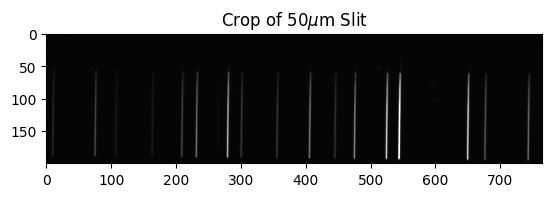

In [12]:
spectra_crop = spectra_data[:200,:]
print(spectra_crop.shape)
plt.imshow(spectra_crop,cmap='gray',vmax=5000)
plt.title(r'Crop of 50$\mu$m Slit')


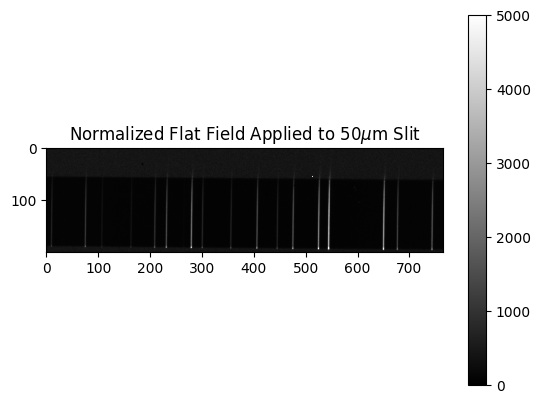

In [13]:
#Apply normalized flat field to arc lamp spectrum using the first order fit
normal = spectra_crop / first_normalized_flat_field

plt.imshow(normal,cmap='gray',vmax=5000)
plt.title(r'Normalized Flat Field Applied to 50$\mu$m Slit')
plt.colorbar()

## 4.5

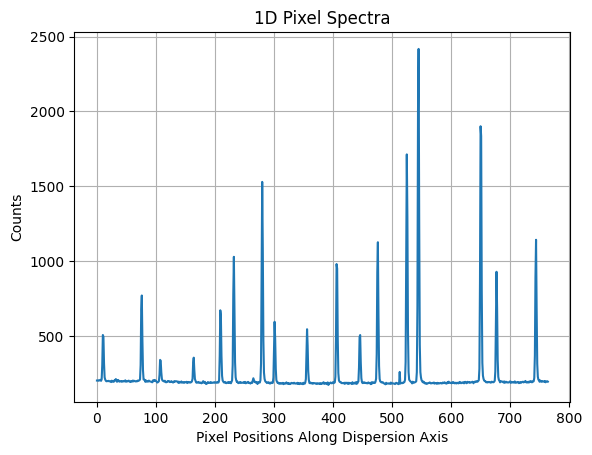

In [14]:
# Calculate the 1D spectra by averaging along the y-axis
flat_field = np.mean(normal, axis=0)

# Plot the 1D pixel counts against pixel positions along the dispersion axis
dispersion_axis = np.arange(765) 

plt.plot(dispersion_axis, flat_field)
plt.xlabel('Pixel Positions Along Dispersion Axis')
plt.ylabel('Counts')
plt.title('1D Pixel Spectra')
plt.grid(True)
plt.show()

17
17
Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 1
Parameters:
            c0                 c1        
    ----------------- -------------------
    586.9612278350182 0.09789476576477951


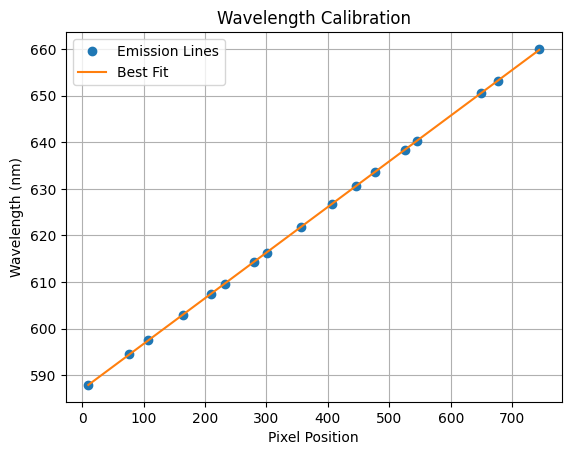

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from astropy.modeling import models, fitting

# Find peaks corresponding to known_wavelengths
peaks, _ = find_peaks(flat_field, height=300)

# Define the pixel positions of identified peaks
pixel_positions = peaks
print(len(pixel_positions))

# Known Neon spectrum emission lines provied by https://www.atomtrace.com/elements-database/element/10
known_wavelengths = [588, 594.5, 597.6,603, 607.5, 609.54, 614.22, 616.3,621.76,626.7, 630.6,633.5,638.4,640.22,650.62,653.22,660]
print(len(known_wavelengths))
    
# Define the model for fitting
linear_model = models.Polynomial1D(degree=1)

# Perform the fitting
fitter = fitting.LinearLSQFitter()
best_fit = fitter(linear_model, pixel_positions, known_wavelengths)

# Plot the data and the best-fit line
plt.plot(pixel_positions, known_wavelengths, 'o', label='Emission Lines')
plt.plot(pixel_positions, best_fit(pixel_positions), label='Best Fit')
plt.xlabel('Pixel Position')
plt.ylabel('Wavelength (nm)')
plt.title('Wavelength Calibration')
plt.grid(True)
plt.legend()

# Display the fit parameters
print(best_fit)
plt.show()


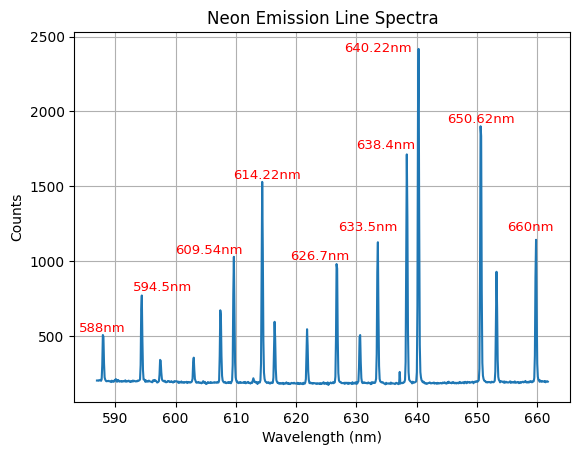

In [16]:
# Using best fit equation, adjust x-axis from pixels to nm
pixels = np.arange(765) 
wavelength_axis = 586.9612278350182 + 0.09789476576477951*pixels

plt.plot(wavelength_axis, flat_field)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Counts')
plt.title('Neon Emission Line Spectra')

#Add labels for stronger emission lines
plt.text(584,530,'588nm',color='red',alpha=1.0,fontsize=9.5)
plt.text(593,800,'594.5nm',color='red',alpha=1.0,fontsize=9.5)
plt.text(600,1050,'609.54nm',color='red',alpha=1.0,fontsize=9.5)
plt.text(609.54,1550,'614.22nm',color='red',alpha=1.0,fontsize=9.5)
plt.text(619,1010,'626.7nm',color='red',alpha=1.0,fontsize=9.5)
plt.text(627,1200,'633.5nm',color='red',alpha=1.0,fontsize=9.5)
plt.text(630,1750,'638.4nm',color='red',alpha=1.0,fontsize=9.5)
plt.text(628,2400,'640.22nm',color='red',alpha=1.0,fontsize=9.5)
plt.text(645,1925,'650.62nm',color='red',alpha=1.0,fontsize=9.5)
plt.text(655,1200,'660nm',color='red',alpha=1.0,fontsize=9.5)

plt.grid(True)
plt.show()

In [17]:
#Find span of spectrograph by taking the range

print(wavelength_axis[0])
print(wavelength_axis[764])
span = wavelength_axis[764] - wavelength_axis[0]

print(f'The length of the spectropgraph is {span}nm ({span*10} Angstroms)')

586.9612278350182
661.7528288793098
The length of the spectropgraph is 74.79160104429161nm (747.9160104429161 Angstroms)


In [18]:
#Divide the range by 765 (number of pixels) to find the dispersion (nm/px)

dispersion = span/765

print(rf'The dispersion is {dispersion*10} A/px')


The dispersion is 0.9776679875070798 A/px
